In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

y_true = np.load('y_true.npy')
y_pred = np.load('y_pred.npy')
y_prob = np.load('y_prob.npy')

print("Loaded predictions successfully.\n")
print(classification_report(y_true, y_pred, target_names=['COVID', 'Normal', 'Viral Pneumonia']))

Loaded predictions successfully.

                 precision    recall  f1-score   support

          COVID       0.26      1.00      0.41      3616
         Normal       0.00      0.00      0.00     10192
Viral Pneumonia       0.02      0.02      0.02      1345

       accuracy                           0.24     15153
      macro avg       0.10      0.34      0.15     15153
   weighted avg       0.06      0.24      0.10     15153



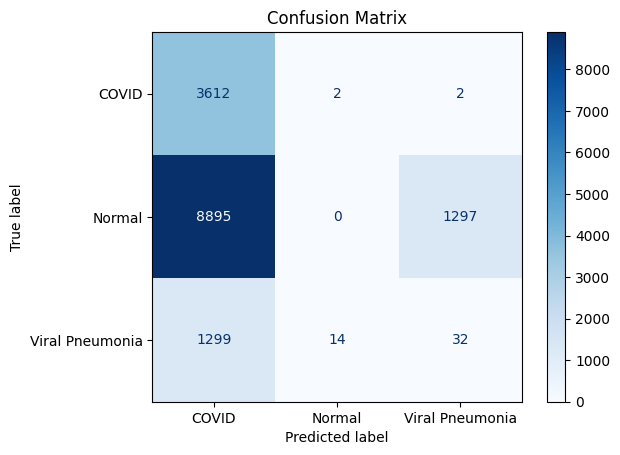

In [31]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'Normal', 'Viral Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

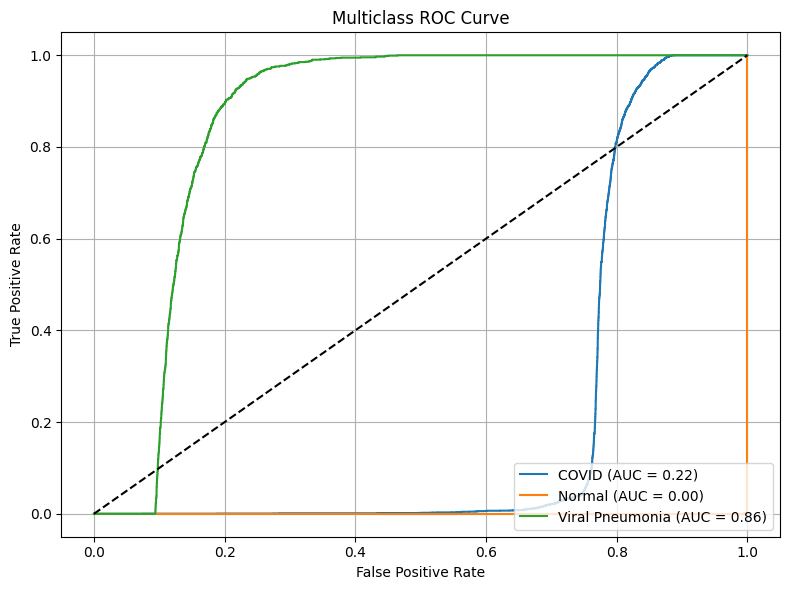

In [32]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved files
y_true = np.load("y_true.npy")
y_pred = np.load("y_pred.npy")
y_prob = np.load("y_prob.npy")

# Classes
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np

print("Shape:", np.array(y_prob).shape)
print("First 5 values:", y_prob[:5])
print("Data type:", type(y_prob[0]))


Shape: (15153, 3)
First 5 values: [[0.95354074 0.03569914 0.01076005]
 [0.8368531  0.12070119 0.04244568]
 [0.833512   0.12233949 0.04414849]
 [0.66596186 0.22560999 0.10842819]
 [0.8430756  0.10581613 0.05110833]]
Data type: <class 'numpy.ndarray'>


In [34]:
import numpy as np

print("y_true shape:", np.array(y_true).shape)
print("y_prob shape:", np.array(y_prob).shape)


y_true shape: (15153,)
y_prob shape: (15153, 3)


🖼 Loading: datasets/COVID-19_Radiography_Dataset/val\COVID\images\COVID-1.png


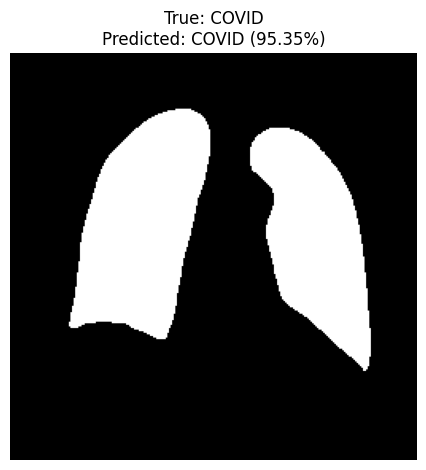

🖼 Loading: datasets/COVID-19_Radiography_Dataset/val\Normal\images\Normal-1.png


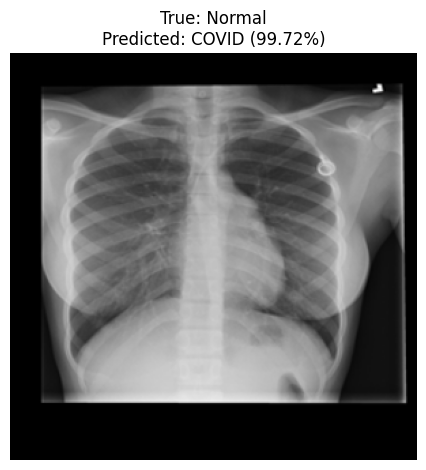

🖼 Loading: datasets/COVID-19_Radiography_Dataset/val\Viral Pneumonia\images\Viral Pneumonia-1.png


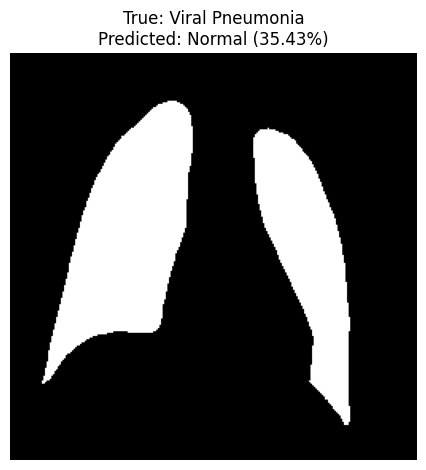

In [35]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Config
class_names = ['COVID', 'Normal', 'Viral Pneumonia']
val_root = 'datasets/COVID-19_Radiography_Dataset/val'
model_path = 'covid_classifier.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Predict one image per class
for class_name in class_names:
    class_folder = os.path.join(val_root, class_name, 'images')  # ✅ FIXED PATH
    image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"❌ No images found in {class_folder}")
        continue

    img_path = os.path.join(class_folder, image_files[0])
    print(f"🖼 Loading: {img_path}")

    try:
        image = Image.open(img_path).convert("RGB")
        transformed = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(transformed)
            probs = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probs, 1)

        plt.imshow(image)
        plt.title(f"True: {class_name}\nPredicted: {class_names[predicted.item()]} ({confidence.item()*100:.2f}%)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")


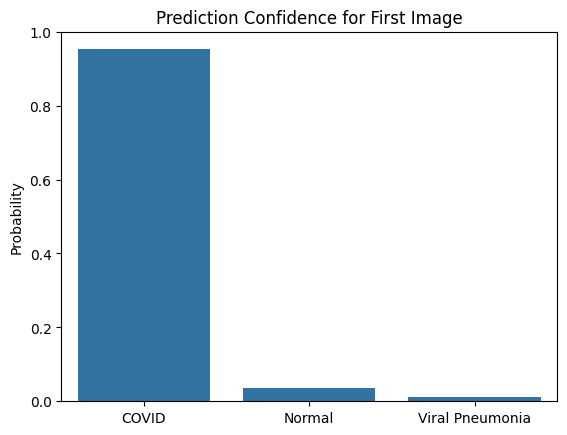

In [36]:
# Plot probability distribution for one sample
import seaborn as sns

sample_probs = y_prob[0]  # first sample
sns.barplot(x=class_names, y=sample_probs)
plt.title("Prediction Confidence for First Image")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()


In [37]:
import os
import shutil

base_dir = 'datasets/COVID-19_Radiography_Dataset'

for cls in ['COVID', 'Normal', 'Viral Pneumonia']:
    src_dir = os.path.join(base_dir, 'train', cls, 'images')  # ✅ updated path
    dst_dir = os.path.join(base_dir, 'val', cls)
    os.makedirs(dst_dir, exist_ok=True)

    if not os.path.exists(src_dir):
        print(f"❌ Source folder missing: {src_dir}")
        continue

    image_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"📁 Found {len(image_files)} images in: {src_dir}")

    for img in image_files[:5]:  # copy first 5 images
        shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))

print("✅ Images copied to val/ folders.")


📁 Found 3616 images in: datasets/COVID-19_Radiography_Dataset\train\COVID\images
📁 Found 10192 images in: datasets/COVID-19_Radiography_Dataset\train\Normal\images
📁 Found 1345 images in: datasets/COVID-19_Radiography_Dataset\train\Viral Pneumonia\images
✅ Images copied to val/ folders.
